# Shrinkage methods: Ridge and LASSO

## Ridge Regression

Ridge regression shrinks coefficients, $\hat{\beta}$, by penalizing the residual sum of squares with a Lagrange multiplier, $\lambda$. 


$$
\hat{\beta}^{ridge} = \operatorname*{arg\,min}_\beta \bigg\{ \sum_{i=1}^{N}\big(y_i - \beta_0 - \sum_{j=1}^{p} x_{ij}\beta_j\big)^2 +\lambda \sum_{j=1}^{p} \beta^2_j\bigg\}
$$

Written as the optimization,



$$
\hat{\beta}^{ridge} = \operatorname*{arg\,min}_\beta \sum_{i=1}^{N}\big(y_i - \beta_0 - \sum_{j=1}^{p} x_{ij}\beta_j\big)^2,\\
\sum_{j=1}^{p} \beta^2_j\leq t
$$

for some $t>0$.
In matrix notation, the lagrangian is written as, 

$$
L(X,t,\lambda^*,\beta ) =\|Y - X\beta\|_2^2 + \lambda^*(\|\beta\|_2^2 - t)
$$

where $\|\bullet\|$ denotes the $L_2$ norm. The optimal solution for the estimator, $\hat{\beta}^{ridge}$, is proved with Karush-Kuhn-Tucker (KKT) conditions,
$\nabla_{\beta} L(X,c,\lambda^*,\beta ) = 0$ (stationarity) and $\lambda^*(\|\beta(\lambda^*)\|_2^2 - t) = 0$ (Complementary slackness
). With the KKT conditions, 

$$
-2X^T(Y-X\beta) + 2t\beta = 0,\\
\lambda^*(\|\beta(\lambda^*)\|_2^2 - t) = 0
$$

Both conditions are satisfied if $\lambda^* = \lambda$ and $t = \lambda^*\|\beta(\lambda^*)\|_2^2$. 

The solution to the ridge estimator is solved similar to linear regression.

$$
RSS = (Y-\beta X)^T(Y-\beta X) - \lambda \beta^T \beta
$$

where the solution is 

$$
\hat{\beta}^{ridge} = (X^TX - \lambda I)^{-1} X^T Y
$$

In [295]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})


import warnings
warnings.filterwarnings("ignore")


#testing with the prostate dataset
df = pd.read_csv('.//prostate.data',sep='\s+')
df.head()


#split train and test
df_train = df.loc[df['train'] == 'T']
df_test = df.loc[df['train'] == 'F']
#drop train column
df_train = df_train.drop(['train'],axis=1)
df_test = df_test.drop(['train'],axis=1)
x_train = df_train[['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']].to_numpy()
y_train = df_train[['lpsa']].to_numpy()
x_test = df_test[['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']].to_numpy()
y_test = df_test[['lpsa']].to_numpy()
predictors = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
p = len(predictors)

#for ridge regression standardize the predictors
x_train = (x_train - np.mean(x_train,axis=0))/np.std(x_train,axis=0)
x_test = (x_test - np.mean(x_test,axis=0))/np.std(x_test,axis=0)

y_train = (y_train - np.mean(y_train,axis=0))/np.std(y_train,axis=0)
y_train = (y_train - np.mean(y_train,axis=0))/np.std(y_train,axis=0)

In [292]:
#Method 1 Use Coordinate descent to sovle for betas 
import copy
beta = np.zeros((x_train.shape[1],1))

#Lasso coefficient
def soft_threshold_l1(t : float,_lambda : float) -> float:
    m = abs(t)
    if t > 0 and m > _lambda:
        return m - _lambda
    elif t < 0 and m > _lambda:
        return _lambda - m
    else:
        return 0.0
    
    
#Ridge coefficient    
def soft_threshold_l2(t : float,_lambda : float) -> float:
    return t / (1.0+_lambda)
    

#lambdas
lambda_tot = 200
lambda_sol = np.zeros((lambda_tot,beta.shape[0]))
lambda_range = np.arange(0,1,1.0/lambda_tot)[::-1]

for k,lval in enumerate(lambda_range):
#Iterative for lambda
    r = y_train - x_train @ beta
    for i in range(0,100):
        #iterate over betas
        for j in range(beta.shape[0]):
            temp_beta = copy.deepcopy(beta)
            temp_beta[j] = 0.0
            r = y_train - x_train @ temp_beta
            xtx = np.sum(x_train[:,j]**2)
            betaj = (1/xtx) * (x_train[:,j].T @ r)
            beta[j] = soft_threshold_l1(betaj[0],lval)

    lambda_sol[k] = beta.T
    

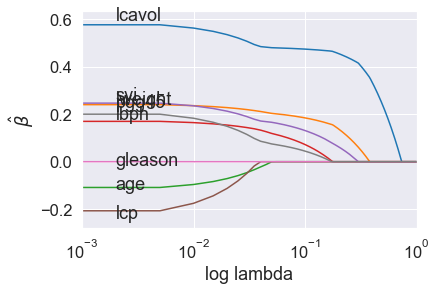

In [294]:
#ridge solution 

sns.palplot(sns.color_palette("hls", 8))



fig, ax = plt.subplots()
x = lambda_range
for m in range(lambda_sol.shape[1]):
    ax.text(0.001+0.001,lambda_sol[:,m][-1],predictors[m])
    ax.semilogx(x, lambda_sol[:,m])
    ax.set_xlabel("log lambda")
    ax.set_ylabel(r"$\hat{\beta}$")
    ax.set_xlim((0.001,1))

In [269]:
predictors[0]

'lcavol'